In [1]:
import glob
import json
import math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# File paths
SAVED_MODEL_FILENAME = "model"
TFL_CC_MODEL_FILENAME = "model.cc"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"

# Image properties
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3

# Fixed-point arithmetic (for rasterization)
FIXED_POINT = 4096

# Data ranges for rasterization
X_RANGE = 0.6  # Max expected x-coordinate deviation from center
Y_RANGE = 0.6  # Max expected y-coordinate deviation from center

LABELS = [
    "0",  # off
    "1",  # on
    "2",  # cello
    "3",  # violin1
    "4",  # violin2
    "5",  # viola
    "6",  # volume down
    "7",  # volume up
]
NUM_CLASSES = len(LABELS)

In [3]:
Path("data").mkdir(parents=True, exist_ok=True)

strokes = []

for filename in glob.glob("data/*.json"):
    with open(filename, "r") as file:
        file_contents = file.read()
    try:
        file_data = json.loads(file_contents)
        for _, stroke in enumerate(file_data["strokes"]):
            stroke["filename"] = filename
            strokes.append(stroke)
    except json.JSONDecodeError:
        print(f"Warning: Could not decode JSON from {filename}")
    except KeyError:
        print(f"Warning: 'strokes' key not found in {filename}")

print(f"Total strokes loaded: {len(strokes)}")


Total strokes loaded: 800


In [ ]:
def mul_fp(a, b):
    return (a * b) // FIXED_POINT


def div_fp(a, b):
    if b == 0:
        b = 1
    return (a * FIXED_POINT) // b


def float_to_fp(a):
    return math.floor(a * FIXED_POINT)


def norm_to_coord_fp(a, range_fp, half_size_fp):
    a_fp = float_to_fp(a)
    norm_fp = div_fp(a_fp, range_fp)
    return mul_fp(norm_fp, half_size_fp) + half_size_fp


def round_fp_to_int(a):
    return math.floor((a + (FIXED_POINT // 2)) / FIXED_POINT)


def gate(a, min_val, max_val):
    if a < min_val:
        return min_val
    elif a > max_val:
        return max_val
    else:
        return a


def rasterize_stroke(stroke_points, x_range, y_range, width, height):
    """
    Rasterizes stroke points into an image buffer with time encoded as color.
    x_range: The expected maximum deviation of x-coordinates from the center (e.g., 0.5 means coords range from -0.5 to 0.5)
    y_range: Similar for y-coordinates.
    width: Output image width in pixels.
    height: Output image height in pixels.
    """
    if not stroke_points or len(stroke_points) < 2:
        return np.zeros((height, width, NUM_CHANNELS), dtype=np.uint8)

    buffer_byte_count = height * width * NUM_CHANNELS
    buffer = bytearray(buffer_byte_count)

    width_fp = float_to_fp(width)
    height_fp = float_to_fp(height)
    half_width_fp = width_fp // 2
    half_height_fp = height_fp // 2
    x_range_fp = float_to_fp(x_range)
    y_range_fp = float_to_fp(y_range)

    num_segments = len(stroke_points) - 1
    if num_segments == 0:  # single point, can't draw lines
        return np.frombuffer(buffer, dtype=np.uint8).reshape(
            height, width, NUM_CHANNELS
        )

    t_inc_fp = FIXED_POINT // num_segments if num_segments > 0 else FIXED_POINT

    one_half_fp = FIXED_POINT // 2

    for point_index in range(num_segments):
        start_point = stroke_points[point_index]
        end_point = stroke_points[point_index + 1]

        start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
        start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
        end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
        end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)

        delta_x_fp = end_x_fp - start_x_fp
        delta_y_fp = end_y_fp - start_y_fp

        # Determine color based on progress through the stroke
        t_fp = point_index * t_inc_fp
        if t_fp < one_half_fp:
            local_t_fp = div_fp(t_fp, one_half_fp)
            one_minus_t_fp = FIXED_POINT - local_t_fp
            red = round_fp_to_int(mul_fp(one_minus_t_fp, float_to_fp(255)))
            green = round_fp_to_int(mul_fp(local_t_fp, float_to_fp(255)))
            blue = 0
        else:
            local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
            one_minus_t_fp = FIXED_POINT - local_t_fp
            red = 0
            green = round_fp_to_int(mul_fp(one_minus_t_fp, float_to_fp(255)))
            blue = round_fp_to_int(mul_fp(local_t_fp, float_to_fp(255)))

        red = gate(red, 0, 255)
        green = gate(green, 0, 255)
        blue = gate(blue, 0, 255)

        # Line drawing algorithm (Bresenham's-like logic for fixed point)
        if abs(delta_x_fp) > abs(delta_y_fp):
            line_length = abs(round_fp_to_int(delta_x_fp))
            if line_length == 0:
                continue
            if delta_x_fp > 0:
                x_inc_fp = float_to_fp(1.0)
                y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
            else:
                x_inc_fp = float_to_fp(-1.0)
                y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
        else:
            line_length = abs(round_fp_to_int(delta_y_fp))
            if line_length == 0:
                continue
            if delta_y_fp > 0:
                y_inc_fp = float_to_fp(1.0)
                x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
            else:
                y_inc_fp = float_to_fp(-1.0)
                x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)

        for i in range(line_length + 1):
            current_x_fp = start_x_fp + mul_fp(
                float_to_fp(i),
                x_inc_fp if abs(delta_x_fp) > abs(delta_y_fp) else x_inc_fp,
            )
            current_y_fp = start_y_fp + mul_fp(
                float_to_fp(i),
                y_inc_fp if abs(delta_x_fp) > abs(delta_y_fp) else y_inc_fp,
            )

            # For the case where we iterate along y:
            if abs(delta_y_fp) >= abs(delta_x_fp):
                current_x_fp = start_x_fp + mul_fp(float_to_fp(i), x_inc_fp)
                current_y_fp = start_y_fp + mul_fp(float_to_fp(i), y_inc_fp)

            x = round_fp_to_int(current_x_fp)
            y = round_fp_to_int(current_y_fp)

            if (x < 0) or (x >= width) or (y < 0) or (y >= height):
                continue

            buffer_index = (y * width * NUM_CHANNELS) + (x * NUM_CHANNELS)
            if buffer_index + 2 < len(buffer):
                buffer[buffer_index + 0] = red
                buffer[buffer_index + 1] = green
                buffer[buffer_index + 2] = blue

    np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(
        height, width, NUM_CHANNELS
    )
    return np_buffer


In [5]:
import shutil
import PIL


def ensure_empty_dir(dirname):
    dirpath = Path(dirname)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    dirpath.mkdir(parents=True, exist_ok=False)


def augment_points(points, move_range, scale_range, rotate_range):
    """Applies random translation, scaling, and rotation to stroke points."""
    move_x = np.random.uniform(low=-move_range, high=move_range)
    move_y = np.random.uniform(low=-move_range, high=move_range)
    scale = np.random.uniform(low=1.0 - scale_range, high=1.0 + scale_range)
    rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

    cos_rot = math.cos(rotate)
    sin_rot = math.sin(rotate)

    x_axis_x = cos_rot * scale
    x_axis_y = sin_rot * scale
    y_axis_x = -sin_rot * scale
    y_axis_y = cos_rot * scale

    new_points = []
    for point in points:
        old_x = point["x"]
        old_y = point["y"]
        # Apply rotation and scale first, then translation
        rotated_scaled_x = (x_axis_x * old_x) + (
            y_axis_x * old_y
        )  # Typo in original: x_axis_y should be y_axis_x for y component
        rotated_scaled_y = (x_axis_y * old_x) + (
            y_axis_y * old_y
        )  # Typo in original: y_axis_x should be x_axis_y for x component
        # Corrected:
        rotated_scaled_x = (cos_rot * old_x - sin_rot * old_y) * scale
        rotated_scaled_y = (sin_rot * old_x + cos_rot * old_y) * scale

        new_x = rotated_scaled_x + move_x
        new_y = rotated_scaled_y + move_y
        new_points.append({"x": new_x, "y": new_y})
    return new_points


def save_strokes_as_images(
    strokes_list, root_folder, width, height, augment_count_per_image
):
    ensure_empty_dir(root_folder)
    for label_str in LABELS:
        label_path = Path(root_folder, label_str)
        ensure_empty_dir(label_path)

    label_counts = {label_str: 0 for label_str in LABELS}

    for stroke in strokes_list:
        points = stroke["strokePoints"]
        label = str(stroke["label"]).strip().lower()
        current_label_count = label_counts[label]
        label_counts[label] += 1

        # Save original rasterized image
        raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
        image = PIL.Image.fromarray(raster)
        image.save(Path(root_folder, label, f"{current_label_count}.png"))

        # Save augmented versions
        for i in range(augment_count_per_image):
            augmented_points = augment_points(
                points, move_range=0.0, scale_range=0.1, rotate_range=0.3
            )
            raster_aug = rasterize_stroke(
                augmented_points, X_RANGE, Y_RANGE, width, height
            )
            image_aug = PIL.Image.fromarray(raster_aug)
            image_aug.save(Path(root_folder, label, f"{current_label_count}_a{i}.png"))

    print(f"Saved images to {root_folder}. Label counts: {label_counts}")


In [6]:
shuffled_strokes = list(strokes)
np.random.shuffle(shuffled_strokes)

# Define dataset split percentages
test_percentage = 20
validation_percentage = 20
train_percentage = 100 - (test_percentage + validation_percentage)

# Calculate counts
total_filtered_strokes = len(shuffled_strokes)
test_count = math.floor((total_filtered_strokes * test_percentage) / 100)
validation_count = math.floor((total_filtered_strokes * validation_percentage) / 100)

# Split
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count : (test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count) :]

print(f"Total strokes for processing: {total_filtered_strokes}")
print(f"Training strokes: {len(train_strokes)}")
print(f"Validation strokes: {len(validation_strokes)}")
print(f"Test strokes: {len(test_strokes)}")

AUGMENT_TRAIN = 10
AUGMENT_VAL = 0
AUGMENT_TEST = 0

# Create the image datasets
if train_strokes:
    save_strokes_as_images(
        train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, AUGMENT_TRAIN
    )
else:
    print("No training strokes to save.")
    Path("train").mkdir(exist_ok=True)

if validation_strokes:
    save_strokes_as_images(
        validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, AUGMENT_VAL
    )
else:
    print("No validation strokes to save.")
    Path("validation").mkdir(exist_ok=True)

if test_strokes:
    save_strokes_as_images(
        test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, AUGMENT_TEST
    )
else:
    print("No test strokes to save.")
    Path("test").mkdir(exist_ok=True)

Total strokes for processing: 800
Training strokes: 480
Validation strokes: 160
Test strokes: 160
Saved images to train. Label counts: {'0': 60, '1': 63, '2': 55, '3': 64, '4': 70, '5': 60, '6': 45, '7': 63}
Saved images to validation. Label counts: {'0': 20, '1': 18, '2': 24, '3': 18, '4': 17, '5': 20, '6': 25, '7': 18}
Saved images to test. Label counts: {'0': 20, '1': 19, '2': 21, '3': 18, '4': 13, '5': 20, '6': 30, '7': 19}


Found 5280 files belonging to 8 classes.
Found 160 files belonging to 8 classes.
Found 160 files belonging to 8 classes.


2025-05-30 22:11:00.612043: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


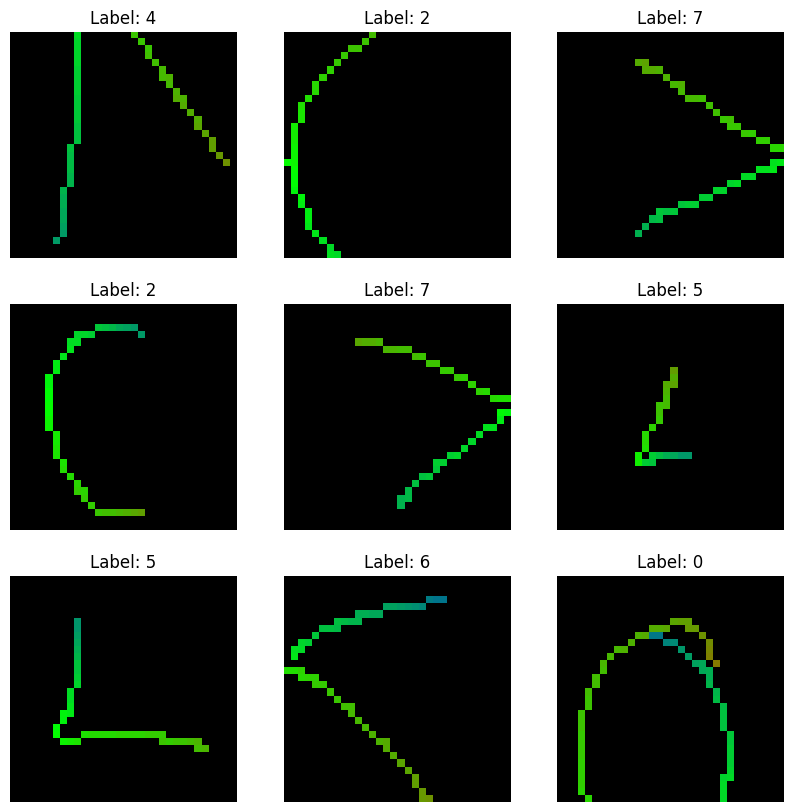

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory


BATCH_SIZE = 32

for label in LABELS:
    Path(f"train/{label}").mkdir(parents=True, exist_ok=True)
    Path(f"validation/{label}").mkdir(parents=True, exist_ok=True)
    Path(f"test/{label}").mkdir(parents=True, exist_ok=True)

loaded_class_names = None

try:
    train_ds_temp = image_dataset_from_directory(
        directory="train",
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        shuffle=True,
        seed=123,
    )
    loaded_class_names = train_ds_temp.class_names
    train_ds = train_ds_temp.prefetch(buffer_size=tf.data.AUTOTUNE)
    del train_ds_temp

    validation_ds_temp = image_dataset_from_directory(
        directory="validation",
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        shuffle=False,
    )
    validation_ds = validation_ds_temp.prefetch(buffer_size=tf.data.AUTOTUNE)
    del validation_ds_temp

    test_ds_temp = image_dataset_from_directory(
        directory="test",
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        shuffle=False,
    )
    test_ds = test_ds_temp.prefetch(buffer_size=tf.data.AUTOTUNE)
    del test_ds_temp

    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = np.argmax(labels[i])
            plt.title(f"Label: {loaded_class_names[label_index]}")
            plt.axis("off")
    plt.show()

except Exception as e:
    print(f"Error loading datasets: {e}")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


def make_model(input_shape, _num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Classifier block
    x = layers.Dropout(0.5)(x)

    activation = "softmax"
    units = _num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model_input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)
model = make_model(input_shape=model_input_shape, _num_classes=NUM_CLASSES)

model.summary()

display(keras.utils.plot_model(model, show_shapes=True, expand_nested=True))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,552 (95.91 KB)

 Trainable params: 24,328 (95.03 KB)

 Non-trainable params: 224 (896.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


None

Starting training for 30 epochs...
Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1891 - loss: 2.0969 - val_accuracy: 0.1688 - val_loss: 2.1940
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4416 - loss: 1.5722 - val_accuracy: 0.2750 - val_loss: 2.0182
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5724 - loss: 1.2446 - val_accuracy: 0.5437 - val_loss: 1.2978
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6579 - loss: 1.0214 - val_accuracy: 0.8750 - val_loss: 0.7118
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7436 - loss: 0.8311 - val_accuracy: 0.8313 - val_loss: 0.6575
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7544 - loss: 0.7445 - val_accuracy: 0.8875 - val_loss: 0.4786
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7866 - loss: 0.6587 - val_accuracy: 0.8438 - val_loss: 0.4951
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.808

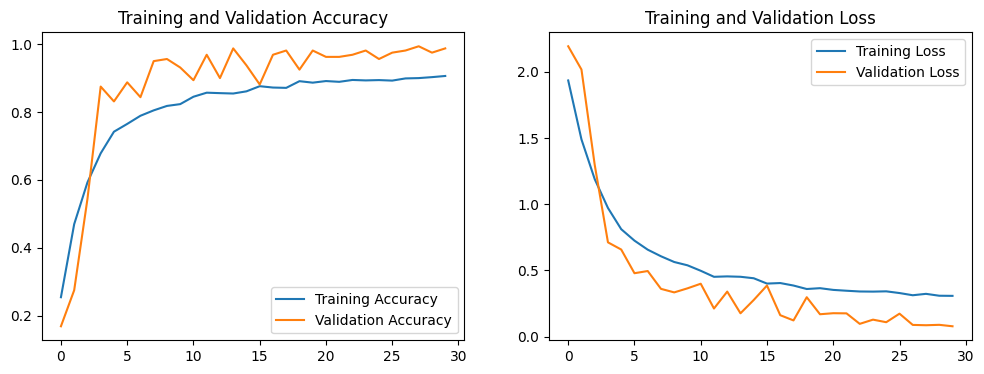

Evaluating model on the test dataset...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0494  
Test Loss: 0.0676
Test Accuracy: 98.75%


In [9]:
EPOCHS = 30
LEARNING_RATE = 1e-3

# ModelCheckpoint to save the best model during training
checkpoint_filepath = "checkpoints/best_model.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

# EarlyStopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback]

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print(f"Starting training for {EPOCHS} epochs...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    validation_data=validation_ds,
)

if history and history.history:
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

model = keras.models.load_model(checkpoint_filepath)

print("Evaluating model on the test dataset...")
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
def predict_image_keras(keras_model, image_path, class_names_list_param):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = keras_model.predict(img_array, verbose=0).flatten()
    predicted_label_index = np.argmax(predictions)
    predicted_score = predictions[predicted_label_index]

    if class_names_list_param and 0 <= predicted_label_index < len(
        class_names_list_param
    ):
        predicted_label_name = class_names_list_param[predicted_label_index]
    else:
        predicted_label_name = f"Unknown (Index {predicted_label_index})"
    return (predicted_label_name, predicted_label_index, predicted_score)


SCORE_THRESHOLD = 0.75
correct_count = 0
wrong_count = 0
discarded_count = 0

print(f"\nDetailed predictions on test images (threshold: {SCORE_THRESHOLD}):")
for label_str in loaded_class_names:
    label_dir = Path("test") / label_str
    for image_file in glob.glob(str(label_dir / "*.png")):
        true_label_name = label_str

        pred_label_name, pred_label_idx, score = predict_image_keras(
            model, image_file, loaded_class_names
        )

        if score < SCORE_THRESHOLD:
            discarded_count += 1
            continue

        if pred_label_name == true_label_name:
            correct_count += 1
        else:
            wrong_count += 1
            print(
                f"File: {Path(image_file).name} - Expected: {true_label_name}, "
                f"Predicted: {pred_label_name} with score {score:.4f}"
            )

if (correct_count + wrong_count) > 0:
    detailed_accuracy = (correct_count / (correct_count + wrong_count)) * 100
    print(
        f"\nDetailed Test Accuracy (above threshold): {detailed_accuracy:.1f}% "
        f"(Correct: {correct_count}, Wrong: {wrong_count}, Discarded: {discarded_count})"
    )

model.export(SAVED_MODEL_FILENAME)
print(f"Model saved to {SAVED_MODEL_FILENAME} folder")



Detailed predictions on test images (threshold: 0.75):

Detailed Test Accuracy (above threshold): 100.0% (Correct: 153, Wrong: 0, Discarded: 7)
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')]
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  13052637264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052625360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052639184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052639952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052639376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052640528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052641104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052634960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052637456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13052637072: TensorSpec(shape=(), dtype=tf.resource, name=None

In [11]:
print(f"\nConverting to Float TFLite model from: {SAVED_MODEL_FILENAME}")
converter_float = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_float_tflite = converter_float.convert()

with open(FLOAT_TFL_MODEL_FILENAME, "wb") as f:
    f.write(model_float_tflite)
print(f"Float TFLite model saved to: {FLOAT_TFL_MODEL_FILENAME}")


def representative_dataset_gen():
    num_calibration_steps = 100
    calibration_ds = train_ds.unbatch().take(num_calibration_steps).batch(1)

    for image_batch, _ in calibration_ds:
        yield [image_batch]


print(f"\nConverting to Quantized INT8 TFLite model from: {SAVED_MODEL_FILENAME}")
converter_quant = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quant.representative_dataset = representative_dataset_gen
converter_quant.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quant.inference_input_type = tf.int8
converter_quant.inference_output_type = tf.int8
model_quantized_tflite = converter_quant.convert()

with open(QUANTIZED_TFL_MODEL_FILENAME, "wb") as f:
    f.write(model_quantized_tflite)
print(f"Quantized INT8 TFLite model saved to: {QUANTIZED_TFL_MODEL_FILENAME}")



Converting to Float TFLite model from: model


W0000 00:00:1748635889.906253 3068605 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748635889.906264 3068605 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-30 22:11:29.906449: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2025-05-30 22:11:29.906957: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-30 22:11:29.906962: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: model
I0000 00:00:1748635889.912084 3068605 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-05-30 22:11:29.913185: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-30 22:11:29.946373: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: model
2025-05-30 22:11:29.956738: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: 

Float TFLite model saved to: float_model.tfl

Converting to Quantized INT8 TFLite model from: model
Quantized INT8 TFLite model saved to: quantized_model.tfl


2025-05-30 22:11:30.161465: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2025-05-30 22:11:30.161984: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-30 22:11:30.161988: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: model
2025-05-30 22:11:30.167999: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-30 22:11:30.201878: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: model
2025-05-30 22:11:30.212233: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 50770 microseconds.
2025-05-30 22:11:30.290553: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [ ]:
def predict_tflite(tflite_model_content, image_path, class_names_list_param):
    """
    Performs inference using a TFLite model and returns predicted label and score.
    """
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    if input_details["dtype"] == np.int8:
        input_scale, input_zero_point = input_details["quantization"]

        if (input_scale, input_zero_point) != (0.0, 0):
            img_array = (img_array / input_scale) + input_zero_point
        img_array = img_array.astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], img_array)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details["index"])[0]

    if output_details["dtype"] == np.int8:
        output_scale, output_zero_point = output_details["quantization"]
        if (output_scale, output_zero_point) != (0.0, 0):
            output_data = output_data.astype(np.float32)
            output_data = (output_data - output_zero_point) * output_scale

    predicted_label_index = np.argmax(output_data)
    predicted_score = output_data[predicted_label_index]
    if class_names_list_param and 0 <= predicted_label_index < len(
        class_names_list_param
    ):
        predicted_label_name = class_names_list_param[predicted_label_index]

    return (predicted_label_name, predicted_label_index, predicted_score)


def evaluate_tflite_model(
    model_content, model_name, class_names_eval, score_threshold_eval
):
    print(
        f"\nEvaluating {model_name} on test images (threshold: {score_threshold_eval}):"
    )
    correct = 0
    wrong = 0
    discarded = 0

    for label_str in class_names_eval:
        label_dir = Path("test") / label_str
        for image_file in glob.glob(str(label_dir / "*.png")):
            true_label_name = label_str

            pred_label_name, _, score = predict_tflite(
                model_content, image_file, class_names_eval
            )

            if score < score_threshold_eval:
                discarded += 1
                continue

            if pred_label_name == true_label_name:
                correct += 1
            else:
                wrong += 1

    accuracy = 0

    if (correct + wrong) > 0:
        accuracy = (correct / (correct + wrong)) * 100
        print(
            f"{model_name} - Accuracy (above threshold): {accuracy:.1f}% "
            f"(Correct: {correct}, Wrong: {wrong}, Discarded: {discarded})"
        )
    return accuracy, correct, wrong, discarded


if Path(FLOAT_TFL_MODEL_FILENAME).exists():
    with open(FLOAT_TFL_MODEL_FILENAME, "rb") as f:
        model_float_tflite_content = f.read()
    evaluate_tflite_model(
        model_float_tflite_content,
        "Float TFLite Model",
        loaded_class_names,
        SCORE_THRESHOLD,
    )

if Path(QUANTIZED_TFL_MODEL_FILENAME).exists():
    evaluate_tflite_model(
        model_quantized_tflite,
        "Quantized INT8 TFLite Model",
        loaded_class_names,
        SCORE_THRESHOLD,
    )



Evaluating Float TFLite Model on test images (threshold: 0.75):
Float TFLite Model - Accuracy (above threshold): 100.0% (Correct: 153, Wrong: 0, Discarded: 7)

Evaluating Quantized INT8 TFLite Model on test images (threshold: 0.75):
Quantized INT8 TFLite Model - Accuracy (above threshold): 100.0% (Correct: 152, Wrong: 0, Discarded: 8)


/Users/phatnguyen/Developer/Conductor/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
import os

if Path(QUANTIZED_TFL_MODEL_FILENAME).exists():
    print(
        f"\nConverting {QUANTIZED_TFL_MODEL_FILENAME} to C source file: {TFL_CC_MODEL_FILENAME}"
    )
    xxd_command = f"xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}"
    if os.system(xxd_command) == 0:
        print(f"Successfully created C source file: {TFL_CC_MODEL_FILENAME}")



Converting quantized_model.tfl to C source file: model.cc
Successfully created C source file: model.cc
